In [1]:
import math
import sys

import IPython
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

from matplotlib import rcParams

rcParams["figure.max_open_warning"] = False
rcParams["font.family"] = 'DejaVu Sans'
rcParams["font.size"] = 14

# 0. Setup

Text(0, 0.5, 'y [m]')

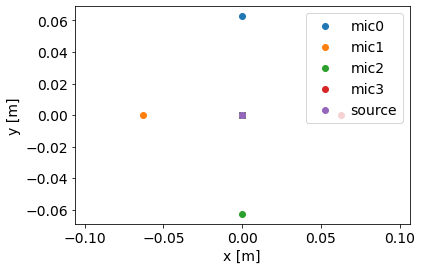

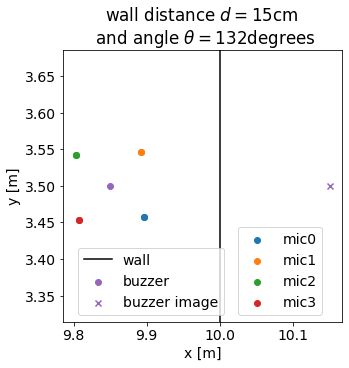

In [4]:
from utils.simulation import get_setup
from utils.plotting_tools import save_fig, FIGSIZE
from utils.geometry import Context
from utils.constants import PLATFORM

if PLATFORM == "crazyflie":
    from crazyflie_description_py.experiments import WALL_ANGLE_DEG_STEPPER
else:
    from epuck_description_py.experiments import WALL_ANGLE_DEG_STEPPER

plot_dir = 'plots/experiments'

distance = 15
#azimuth_deg = WALL_ANGLE_DEG_STEPPER #- 180
azimuth_deg = WALL_ANGLE_DEG_STEPPER #- 180

context = Context.get_platform_setup()
context.plot()

fig, ax = plt.subplots()
fig.set_size_inches(FIGSIZE, FIGSIZE)
source, mic_positions = get_setup(distance_cm=distance, azimuth_deg=azimuth_deg)
[ax.scatter(*mic[:2], label=f'mic{i}, $\\theta=${azimuth_deg}$^\\circ$') for i, mic in enumerate(mic_positions)]

source, mic_positions = get_setup(distance_cm=distance, azimuth_deg=azimuth_deg, ax=ax)
ax.set_title(f"wall distance $d=${distance}cm \n and angle $\\theta=${azimuth_deg}degrees")
handles, labels = ax.get_legend_handles_labels()
h_mics = {l.split(', $\\theta')[0]: h for h, l in zip(handles, labels) if '\\theta' in l}
l1 = ax.legend(h_mics.values(), h_mics.keys(),loc="lower left", bbox_to_anchor=[0.6, 0])

h_other = {l: h for h, l in zip(handles, labels) if not 'mic' in l}
ax.legend(h_other.values(), h_other.keys(),loc="lower right", bbox_to_anchor=[0.6, 0])
ax.add_artist(l1)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
#save_fig(fig, f'{plot_dir}/setup_{PLATFORM}.pdf')

In [ ]:
if PLATFORM == "crazyflie":
    exp_name = "2021_07_08_stepper_fast"; # thesis
    #exp_name = "2021_10_07_stepper"
    motors = "all45000"
    snr = 5
else:
    exp_name = "2021_07_27_epuck_wall"; # new sweep, better pipeline
    motors = "sweep_and_move" 
    snr = 0
mic_type = "audio_deck"

In [ ]:
from utils.data_collector import DataCollector

data_collector = DataCollector()
backup_exists = data_collector.fill_from_backup(exp_name, mic_type, motors, snr)
if not backup_exists: 
    print('generate data using script generate_df_results.')
df_matrix, df_dist, df_freq = data_collector.get_df_matrix()

# 1. Distance slices

In [ ]:
def plot_slices(slice_exp, slice_the, dist):
    fig_f, axs_f = plt.subplots(1, slice_exp.shape[0], squeeze=False, sharey=True)
    fig_f.set_size_inches(2*FIGSIZE, FIGSIZE)
    fig_f.suptitle(f"Standardized distance slices, at frequency {f:.0f}Hz")
    for m in range(slice_exp.shape[0]):
        slice_exp_norm = deepcopy(slice_exp[m])
        slice_the_norm = deepcopy(slice_the[m])
        slice_exp_norm -= np.mean(slice_exp_norm)
        slice_the_norm -= np.mean(slice_the_norm)
        slice_exp_norm /= np.std(slice_exp_norm)
        slice_the_norm /= np.std(slice_the_norm)
        
        axs_f[0, m].plot(dist, slice_the_norm, label="theoretical")
        axs_f[0, m].plot(dist, slice_exp_norm, label="measured")
        axs_f[0, m].set_title(f"mic{m}")
        axs_f[0, m].legend(loc="upper right")
        axs_f[0, m].set_xlabel("distance [cm]")
        axs_f[0, m].grid()
    axs_f[0, 0].set_ylabel("amplitude")
    return fig_f

In [ ]:
from utils.pandas_utils import fill_nans
from utils.simulation import get_dist_slice_theory
from copy import deepcopy

for i, f in enumerate(df_freq):
        
    slice_exp = df_matrix[:, i, :]
    if np.any(np.isnan(slice_exp)):
        slice_exp = fill_nans(slice_exp, df_dist)
    slice_the = get_dist_slice_theory(f, df_dist, azimuth_deg=azimuth_deg).T
    
    fig_d = plot_slices(
        slice_exp=slice_exp,
        slice_the=slice_the,
        dist=df_dist,
    )
    fname = f"{exp_name}_{motors}"
    if f in [2562, 3375, 4500]: # manually picked these
        save_fig(fig_d, f'{plot_dir}/{fname}_distance_slice_{f:.0f}.pdf')

In [ ]:
from utils.simulation import factor_distance_to_delta

d1 = df_dist[-1] # starting distance of distance slice. 
rel_movement_cm = df_dist[1]-df_dist[0]
factors = {mic:factor_distance_to_delta(d1, 
                                        rel_movement_cm, 
                                        mic, azimuth_deg=azimuth_deg) 
           for mic in range(4)}
print('factors_max:\n', factors)
dN = df_dist[0] # ending distance of distance slice. 
factors_min = {mic:factor_distance_to_delta(dN, 
                                        rel_movement_cm, 
                                        mic, azimuth_deg=azimuth_deg) 
               for mic in range(4)}
print('factors_min:\n', factors_min)
average = np.mean(list(factors.values())+list(factors_min.values()))
print('average', average)

In [ ]:
from utils.inference import get_approach_angle_fft, get_gamma_distribution, get_approach_angle_cost
from utils.plotting_tools import plot_performance, save_fig, titles, linestyles
from utils.estimators import get_estimate, AngleEstimator
from utils.inference import BAD_FREQ_RANGES, PLATFORM

plot_slices = True
gamma_min = 10

start_distances_grid = [max(df_dist)+10] #[max(df_dist) + i for i in [0, 10, 20]]
gammas_grid = np.arange(gamma_min, 91, step=1)

factor = 2.0 # correction factor, 2 means we assume colocated
gt_gamma = 90 # in degrees

fig, ax_total = plt.subplots()
ax_total.set_xlabel('approach angle $\\gamma$')
ax_total.set_ylabel('probability')
ax_total.set_title('combined distribution across mics and frequencies')

#for algo in ["bayes"]#["cost", "bayes"]:
#algo = "cost" #"bayes"
algo = "bayes" #"bayes"
    
estimator_all = AngleEstimator()

labels = ["all mics"] + [f"mic{m}" for m in range(df_matrix.shape[0])] 
err_dict = {l: [np.nan]*len(df_freq) for l in labels}

print(df_freq)
for i, f in enumerate(df_freq):
    if np.any([r[0] <= f <= r[1] for r in BAD_FREQ_RANGES]):
        print('skipping', f)
        continue
    estimator = AngleEstimator()

    d_slices = fill_nans(df_matrix[:, i, :], df_dist)

    if plot_slices:
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(7, 5)
    for mic_idx in range(df_matrix.shape[0]):
        d_slice = d_slices[mic_idx] ** 2

        if algo == "bayes":
            ratios, prob_ratios = get_approach_angle_fft(d_slice, f, df_dist,
                                                         n_max=1000, bayes=True, 
                                                         reduced=False, 
                                                         factor=factor)
            gammas, prob = get_gamma_distribution(deepcopy(ratios), 
                                                  deepcopy(prob_ratios))
                                                  #factors[mic_idx])
        elif algo == "cost":
            prob = get_approach_angle_cost(
                d_slice,
                f,
                df_dist,
                start_distances_grid,
                gammas_grid,
                mic_idx=mic_idx,
                azimuth_deg=azimuth_deg
            )  # is of shape n_start_distances x n_gammas_grid
            gammas = gammas_grid
            
        prob = prob[gammas > gamma_min]
        gammas = gammas[gammas > gamma_min]
        
        estimator_all.add_distribution(gammas, prob, mic_idx, f)
        estimator.add_distribution(gammas, prob, mic_idx, f)

        gamma = get_estimate(gammas, prob)
        
        err_dict[f"mic{mic_idx}"][i] = gamma - gt_gamma

        if plot_slices:
            axs[0].plot(ratios, prob_ratios)
            axs[0].axvline(1.0, label=f'mic{mic_idx}, {algo}', color=f'C{mic_idx}', ls=linestyles[algo])
            axs[0].set_xlim(0, 2)
            
            axs[1].plot(gammas, prob)
            axs[1].axvline(gamma, label=f'mic{mic_idx}, {algo}', color=f'C{mic_idx}', ls=linestyles[algo])

    if plot_slices:
        axs[1].set_title(f'frequency {f:.0f}Hz')
        axs[1].set_xlabel('angle of approach $\\gamma$ [$^\\circ$]')
        axs[1].set_ylabel('probability')
        axs[1].legend()

    #angles, prob = estimator.get_angle_distribution(mics_left_right=[[1, 2], [0, 3]])
    angles, prob = estimator.get_angle_distribution(mics_left_right=None)
    
    gamma = get_estimate(angles, prob)
    err_dict["all mics"][i] = gamma - gt_gamma

#angles, prob = estimator_all.get_angle_distribution(mics_left_right=[[1, 2], [0, 3]])
angles, prob = estimator_all.get_angle_distribution(mics_left_right=None)
ax_total.plot(angles, prob, label=algo)

fname = f"{exp_name}_{motors}"
fig, axs = plot_performance(err_dict, xs=df_freq, 
           xlabel="frequency [Hz]", ylabel="error [$^\\circ$]")
max_err = 90 #45
axs[1].set_xlim(0,  max_err)
axs[0].set_ylim(-max_err, max_err)
save_fig(fig, f'{plot_dir}/{fname}_{algo}_distance_slice_performance.pdf')

ax_total.legend()

# 2. Matrix analysis 

## 2.1 Calibration

In [ ]:
from utils.calibration import get_calibration_function_median

if PLATFORM == "epuck":
    motors_list = ["sweep_and_move"]
else:
    motors_list = ["all45000", 0]

for motors_here in motors_list:
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(10, 5)
    calib_function_median, freqs = get_calibration_function_median(
        exp_name, mic_type, snr=snr, ax=axs[0], motors=motors_here
    )
    axs[0].legend(loc='lower right')
    axs[0].set_title("calibration-individual")

    calib_function_median_one, freqs = get_calibration_function_median(
        exp_name, mic_type, ax=axs[1], fit_one_gain=True, snr=snr, motors=motors_here
    )
    axs[1].set_title("calibration-global")
    axs[1].set_ylabel('')
    axs[1].legend().set_visible(False)
    save_fig(fig, f'{plot_dir}/{exp_name}_calibration_median_{motors_here}.pdf')

In [ ]:
from utils.simulation import get_df_theory
from utils.data_collector import normalize_df_matrix

results = pd.DataFrame(columns=["normalization", "matrix", "values"])
method_dict = {
    'raw': "",
    'theoretical': "",
    'calibration-individual': calib_function_median,
    'calibration-global': calib_function_median_one,
}

for j, (key, method) in enumerate(method_dict.items()):
    values = None
    if key == "raw":
        df_norm = deepcopy(df_matrix)
    elif key == "theoretical":
        df_theory_pruned = get_df_theory(df_freq, df_dist)
        df_norm = deepcopy(df_theory_pruned)
    else:
        df_norm, values = normalize_df_matrix(
            df_matrix=df_matrix, freqs=df_freq, method=method
        )
    results.loc[len(results), :] = {
        "normalization": key,
        "matrix": df_norm,
        "values": values,
    }
    # print(key, data_type, df_norm.shape)
print('done')

In [ ]:
from utils.plotting_tools import plot_df_matrix, save_fig, titles, add_colorbar

min_freq = min(df_freq) #3100 #min(df_freq)
max_freq = max(df_freq) #5000 #max(df_freq)

min_value = None
max_value = None

fname = f"{exp_name}_{motors}"

figsize = 4

for normalization, df in results.groupby("normalization", sort=False):
    matrix = df.iloc[0].matrix
    n_mics = matrix.shape[0]
    fig, axs = plt.subplots(1, n_mics, sharey=True)
    fig.set_size_inches(n_mics*figsize, figsize)
    axs[0].set_ylabel('frequency [Hz]')
    for i in range(n_mics):
        df_exp = df.iloc[0].matrix[i]
        ax, im = plot_df_matrix(
            df_dist,
            df_freq,
            df_exp,
            ax=axs[i],
            min_freq=min_freq,
            max_freq=max_freq,
            vmin=min_value,
            vmax=max_value,
        )
        ax.set_title(f"mic{i} {normalization}")
        ax.set_xlabel('distance [cm]')
    add_colorbar(fig, ax, im)
    #save_fig(fig, f"plots/{fname}_matrices_{normalization}.png")
    
mic_idx = 1
fig, axs = plt.subplots(1, len(method_dict), sharey=True)
fig.set_size_inches(len(method_dict)*figsize, figsize) 
axs[0].set_ylabel('frequency [Hz]')
for i, (normalization, df) in enumerate(results.groupby("normalization", sort=False)):
    matrix = df.iloc[0].matrix
    print(np.min(matrix), np.max(matrix))
    n_mics = matrix.shape[0]
    df_exp = df.iloc[0].matrix[mic_idx]
    ax, im = plot_df_matrix(
        df_dist,
        df_freq,
        df_exp,
        ax=axs[i],
        min_freq=min_freq,
        max_freq=max_freq,
        vmin=min_value,
        vmax=max_value,
    )
    ax.set_title(f"{normalization}")
    ax.set_xlabel('distance [cm]')
add_colorbar(fig, ax, im)
save_fig(fig, f"{plot_dir}/{fname}_matrices_mic{mic_idx}.png")

# 3. Frequency slices

In [ ]:
from utils.calibration import get_calibration_function_median
from utils.estimators import DistanceEstimator, get_estimate
from utils.inference import Inference
from utils.simulation import get_freq_slice_theory
import progressbar

EPS = 1e-10  # clip probability distribution at this value
err_df = pd.DataFrame(
    columns=['method', 'mic', 'distance', 'error', 'algorithm'])

distance_range = [min(df_dist), max(df_dist)]
inf_machine = Inference()

inf_machine.add_geometry(distance_range, azimuth_deg)

chosen_mics = range(4) #[0, 1, 3] #range(4)
n_mics = len(chosen_mics)

use_uniform_prior = True

context = Context.get_platform_setup()
distances_grid_m = context.get_possible_distances() #np.arange(50) 
distance_estimators = {}

with progressbar.ProgressBar(max_value=len(df_dist)) as p:
    for i_d, distance in enumerate(df_dist):

        distance_estimators = {
            k: DistanceEstimator()
            for k in method_dict.keys()
        }

        p.update(i_d)
        for method, normalize_method in method_dict.items():
            if method == "theoretical":
                # squared:
                slice_exp = get_freq_slice_theory(df_freq,
                                                  distance,
                                                  azimuth_deg=azimuth_deg, 
                                                  chosen_mics=chosen_mics)
                slice_exp = np.sqrt(slice_exp.T) # now it's 4x32
                freqs = df_freq
            else:
                # non-squared:
                slice_exp, freqs, stds = data_collector.get_frequency_slice_fixed(
                    df_freq,
                    distance,
                    mics=chosen_mics)
            inf_machine.add_data(slice_exp, df_freq, mics=chosen_mics)
            inf_machine.filter_out_freqs()
            inf_machine.add_calibration_function(normalize_method)
                
            for i_mic, mic_idx in enumerate(chosen_mics):
                distances_bayes, proba_bayes_norm, diff_bayes = inf_machine.do_inference(
                    algorithm="bayes", 
                    mic_idx=i_mic
                )
                
                for algo in ["cost", "bayes"]:
                    distances_here, proba, diff = inf_machine.do_inference(
                        algorithm=algo, 
                        mic_idx=i_mic)
                    d = get_estimate(distances_here, proba)
                    err_df.loc[len(err_df), :] = {
                        'error': d - distance,
                        'mic': mic_idx,
                        'distance': distance,
                        'method': method,
                        'algorithm': algo
                    }
                    if algo == "bayes":
                        distance_estimators[method].add_distribution(
                            diff * 1e-2, proba, mic_idx)

        for method, distance_estimator in distance_estimators.items():
            azimuth_deg_here = None if use_uniform_prior else azimuth_deg
            distances_here, proba = distance_estimator.get_distance_distribution(
                distances_m=distances_grid_m,
                azimuth_deg=azimuth_deg_here)
            d = get_estimate(distances_here, proba) * 1e2
            err_df.loc[len(err_df), :] = {
                'error': d - distance,
                'mic': 'all',
                'distance': distance,
                'method': method,
                'algorithm': 'bayes-combination'
            }

            # angle distribution doesn't work with uniform prior!
            # this is normal, there is no information on angle without some distance information.
            distance_m_here = distance * 1e-2
            angles_here, proba = distance_estimator.get_angle_distribution(
                distance_estimate_m=distance_m_here,
                azimuths_deg=np.arange(360))
            a = get_estimate(angles_here, proba)
            error = np.diff(
                np.unwrap([a / 180 * np.pi, azimuth_deg / 180 * np.pi])) * 180 / np.pi
            err_df.loc[len(err_df), :] = {
                'error': error[0],
                'mic': 'all',
                'distance': distance,
                'method': method,
                'algorithm': 'bayes-combination-angle'
            }
err_df = err_df.apply(pd.to_numeric, axis=0, errors='ignore')

In [ ]:
from utils.plotting_tools import plot_performance

fname = f"{exp_name}_{motors}"
if use_uniform_prior:
    fname += "_uniform"
    
for key, df in err_df.groupby("algorithm"):
    if "angle" in key:
        continue
    for mic, df_mic in df.groupby("mic"):
        absolute_err = pd.pivot_table(df_mic, index="distance", values="error", columns="method")
        
        # TODO: need to figure out if we need to replace df_dist below by distance again.
        # that's what it was for stepper motor results
        fig, axs = plot_performance(absolute_err, xs=df_dist, xlabel="distance [cm]", ylabel="error [cm]")
        axs[0].grid()
        #fig.suptitle(f'microphone: {mic}') #', {titles[key]}')
        axs[1].set_xlim(-1, max(distances_grid_m * 1e2))
        
        fname_here = f"{plot_dir}/{fname}_{key}_mic{mic}_frequency_performance.png"
        save_fig(fig, fname_here)

In [ ]:
for key, df in err_df.groupby("algorithm"):
    if not "angle" in key:
        continue
    for mic, df_mic in df.groupby("mic"):
        absolute_err = pd.pivot_table(df_mic, index="distance", values="error", columns="method")
        
        fig, axs = plot_performance(absolute_err, 
                                    xs=df_dist, xlabel="distance [cm]", ylabel="error [deg]")
        axs[0].grid()
        
        fname_here = f"{plot_dir}/{fname}_{key}_mic{mic}_frequency_performance.png"
        save_fig(fig, fname_here)

In [ ]:
from utils.inference import eps_normalize
from utils.simulation import get_freq_slice_theory
from utils.plotting_tools import all_linestyles

mic_idx = 1
eps = 1e-5

plot_combis = [
    #{"distance": 15, "algorithm": "cost"},
    {"distance": 15, "algorithm": "bayes"},
    #{"distance": 17, "algorithm": "bayes"},
    #{"distance": 28, "algorithm": "bayes"},
]
print("using uniform prior:", use_uniform_prior)

for plot_combi in plot_combis:
    distance = plot_combi.get("distance")
    algorithm = plot_combi.get("algorithm")

    shape = (1, n_mics)
    # plot the slices
    fig_slice, axs_slice = plt.subplots(*shape, sharex=True, sharey=True)
    fig_slice.set_size_inches(3 * shape[1], 2 * shape[0])
    # plot the results 
    fig_algo, axs_algo = plt.subplots(*shape, sharex=True, sharey=True)
    fig_algo.set_size_inches(3 * shape[1], 2 * shape[0])

    distance_estimators = {k: DistanceEstimator() for k in method_dict.keys()}
    for i_method, (method, normalize_method) in enumerate(method_dict.items()):
        if method == "theoretical":
            slice_exp = get_freq_slice_theory(df_freq,
                                              distance,
                                              azimuth_deg=azimuth_deg, 
                                              chosen_mics=chosen_mics)
            slice_exp = slice_exp.T # now it's 4x32
            freqs = df_freq
        else:
            slice_exp, freqs, stds = data_collector.get_frequency_slice_fixed(
                df_freq,
                distance,
                mics=chosen_mics)
            slice_exp = np.sqrt(slice_exp)
            
            
        inf_machine.add_data(slice_exp, df_freq, mics=chosen_mics)
        inf_machine.filter_out_freqs()
        inf_machine.add_calibration_function(normalize_method)

        for i_mic, mic_idx in enumerate(chosen_mics):
            distances_bayes, proba_bayes_norm, diff_bayes = inf_machine.do_inference(
                algorithm="bayes", 
                mic_idx=i_mic,
                #normalize=False
            )
            
            inf_machine.plot(i_mic=i_mic, ax=axs_slice[i_mic], label=method, standardize=True,
                             ls=all_linestyles[i_method])#marker='o')

            distance_estimators[method].add_distribution(
                diff_bayes * 1e-2, proba_bayes_norm, mic_idx
            )
            d = get_estimate(distances_bayes, proba_bayes_norm)

            axs_algo[i_mic].semilogy(
                distances_bayes,
                eps_normalize(proba_bayes_norm, eps=eps),
                color=f"C{i_method}",
                ls=all_linestyles[i_method],
                label=method,
            )
            axs_algo[i_mic].axvline(x=d, color=f"C{i_method}", ls=":") 
            axs_algo[i_mic].set_title(f"mic{mic_idx}")
            axs_slice[i_mic].set_title(f"mic{mic_idx}")
        
    label_real = f"real: {distance:.0f}cm"
    #axs_slice[-1].legend(title=label_real, bbox_to_anchor=[1.0, 1.0], loc='upper left')
    #axs_algo[-1].legend(title=label_real, bbox_to_anchor=[1.0, 1.0], loc='upper left')
    axs_slice[0].set_ylabel('amplitude') 
    axs_algo[0].set_ylabel('probability') 
    [ax.set_xlabel('frequency [Hz]') for ax in axs_slice]
    [ax.set_xlabel('distance [cm]') for ax in axs_algo]

    fname_here = f"{plot_dir}/{fname}_{distance}cm_raw_slices.png"
    save_fig(fig_slice, fname_here)
    fname_here = f"{plot_dir}/{fname}_{distance}cm_raw_results.png"
    save_fig(fig_algo, fname_here)

    fig_combi, axs_combi = plt.subplots(1, 2)
    fig_combi.set_size_inches(6, 3)
    
    print("getting distance distribution...")
    ax_combi = axs_combi[0]
    for i_method, (method, distance_estimator) in enumerate(
        distance_estimators.items()
    ):
        azimuth_deg_here = None if use_uniform_prior else azimuth_deg_here
        distances_m, proba = distance_estimator.get_distance_distribution(
            azimuth_deg=azimuth_deg_here, distances_m=distances_grid_m, verbose=False,
            method="sum"
        )
        ax_combi.plot(
            distances_m*1e2,
            eps_normalize(proba, eps=eps),
            color=f"C{i_method}",
            ls=all_linestyles[i_method],
            label=method,
        )
    ax_combi.axvline(x=distance, color="black", ls=":")
    ax_combi.set_xlabel("distance [cm]")
    ax_combi.set_ylabel("probability")
    #ax_combi.set_title("total probability")
    ax_combi.set_yscale("log")

    print("getting angle distribution...")
    ax_combi = axs_combi[1]
    for i_method, (method, distance_estimator) in enumerate(
        distance_estimators.items()
    ):

        # doesn't work with uniform prior!!
        distance_m_here = d * 1e-2
        angles, proba = distance_estimator.get_angle_distribution(
            distance_estimate_m=distance_m_here,
            azimuths_deg=np.arange(360),
            method="sum",
        )
        ax_combi.plot(
            angles,
            eps_normalize(proba, eps=eps),
            color=f"C{i_method}",
            ls=all_linestyles[i_method],
            label=method,
        )
    ax_combi.axvline(
        x=azimuth_deg, color="black", ls=":", label=f"real: {distance:.0f}cm, {azimuth_deg:.0f}$^\\circ$"
    )
    ax_combi.legend(loc="upper left", bbox_to_anchor=[1.0, 1.0])
    ax_combi.set_xlabel("angle [$^\\circ$]")
    #ax_combi.set_title("total probability")
    ax_combi.set_yscale("log")
    plt.subplots_adjust(wspace=0.25)

    fname_here = f"{plot_dir}/{fname}_{distance}cm_raw_total.png"
    save_fig(fig_combi, fname_here)

# 4. Calibration analysis

In [ ]:
exp_name = "2021_07_08_stepper_fast"
mic_type = "audio_deck"
motors = "all45000"
snr = 5
plot_tuples = [(0, 3125)]

data_collector = DataCollector()
backup_exists = data_collector.fill_from_backup(exp_name, mic_type, motors, snr=snr)
if not backup_exists: 
    print('generate data using script generate_df_results.')

In [5]:
from utils.calibration import fit_distance_slice
from utils.simulation import get_amplitude_function

fname = f'{exp_name}_{motors}'
all_distances = data_collector.df.distance.unique()

mic_idx = 0
max_distance = 35

for i, (frequency, df_freq_here) in enumerate(data_collector.df.groupby('frequency')):
    distances = df_freq_here.distance.unique()
    if len(distances) < len(all_distances): # only plot distances with "full coverage"
        continue
    
    df_here = df_freq_here.loc[df_freq_here.mic==mic_idx]
        
    coeffs_median, distances_median, fit_median, cost_median = data_collector.fit_to_median(frequency, [mic_idx])
    alpha, offset, gain = coeffs_median
        
    # find the sigma for this frequency (per distance)
    std_series = df_here.groupby('distance').magnitude.std() # per distance
    std_average = np.nanmean(std_series.values)
    amps = get_amplitude_function(std_series.index, 
                                  gain, 
                                  alpha, mic_idx)
    valid_distances = std_series.index[amps >= std_average]
    limit_distance = valid_distances[-1] if len(valid_distances) else 0

    #print(f'raw: mic {mic}, frequency {frequency}')
    #print(f'median: alpha={alpha:.2f}, gain={gain:.2f}, offset={offset:.0f}, cost={cost_median}')


    label = f"{frequency:.0f}Hz"
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    ax_fit, ax_freq = axs
    
    slices_median, distances_median_all, mics, stds = data_collector.get_distance_slice(frequency)
    for d, series in df_here.groupby('distance').magnitude: 
        ax_fit.scatter([d]*len(series), series.values, color='C0', s=4)#, s=5.0)
    ax_fit.scatter([], [], color='C0', label='raw', s=4)#, s=5.0)

    ax_fit.plot(distances_median_all, slices_median[mic_idx, :], color='C0', label='distance slice')
    ax_fit.plot(distances_median, fit_median, color='C1', label='model fit')

    ax_fit.set_title('fit for ' + label)
    ax_fit.set_ylabel('amplitude [-]')
    ax_fit.set_xlabel('distance [cm]')
    ax_fit.legend(loc='lower left')
    ax_fit.set_xlim(min(distances_median), max_distance)

    ax_freq.semilogy(std_series.index, amps, ls=':', color=f'C0', label=f'magnitude')
    ax_freq.axhline(std_average, label=f'average std', color=f'C0')
    ax_freq.scatter(std_series.index, std_series.values, label=f'std', color=f'C0', s=4)
    ax_freq.set_xlim(min(distances_median), max_distance)

    ax_freq.set_title('magnitude vs. noise for ' + label)
    ax_freq.legend(loc='lower left')
    ax_freq.set_xlabel('distance [cm]')
    #ax_freq.set_ylabel('magnitude vs. std [-]')

    if (mic_idx, frequency) not in plot_tuples:
        continue
        
    fname_here = f'{plot_dir}/{fname}_fitting_{frequency:.0f}_{mic_idx}.png'
    save_fig(fig, fname_here)

NameError: name 'exp_name' is not defined